# Factoring and period finding

In [3]:
"""
Factoring and period finding
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
import sys

np.set_printoptions(threshold=sys.maxsize)

from fractions import Fraction

from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram

In [4]:
# Directly prepare the quantum state:
def get_coeffs(x, N, n_q, n_count):
    """
    x-> guess
    N-> target number
    n_q -> number of qubits
    n_count -> number qubits for qft #t
    """
    vec = np.zeros(2 ** n_q)
    base = 1
    for i in range(2 ** n_count):
        s1 = np.binary_repr(i, n_count)
        mod2 = np.mod(base, N)
        base = mod2 * x
        s2 = np.binary_repr(mod2, n_q - n_count)
        print(i, mod2, s1, s2)
        vec[int(s2 + s1, 2)] = 1
    return vec


def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi / float(2 ** (j - m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc


##  Example: x=3, N=15:

In [5]:
# Example: x=3, N=15:

x = 3
N = 15
n_q = 10  # total number of Qubits (QFT_register + a**i_register)
n_count = 4  # number of qubits of QFT_register

print("x:", x)
print("N:", N)
print("n_q:", n_q)
print("n_count:", n_count)

vec = get_coeffs(x, N, n_q, n_count)
vec =  np.multiply(vec, 1/np.sqrt(2**n_count))
print("vec:", vec)


x: 3
N: 15
n_q: 10
n_count: 4
0 1 0000 000001
1 3 0001 000011
2 9 0010 001001
3 12 0011 001100
4 6 0100 000110
5 3 0101 000011
6 9 0110 001001
7 12 0111 001100
8 6 1000 000110
9 3 1001 000011
10 9 1010 001001
11 12 1011 001100
12 6 1100 000110
13 3 1101 000011
14 9 1110 001001
15 12 1111 001100
vec: [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.25 0.   0.   0.   0.25 0.   0.
 0.   0.25 0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.25 0.   0.   0.   0.25 0.   0.   0.   0.25 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0. 

In [ ]:
## Simulation:

Q = QuantumCircuit(n_q,n_count)
Q.initialize(vec)

Q.append(qft_dagger(n_count),range(n_count))
Q.measure(range(n_count),range(n_count))
Q.draw(fold=-1)  # -1 means 'do not fold'

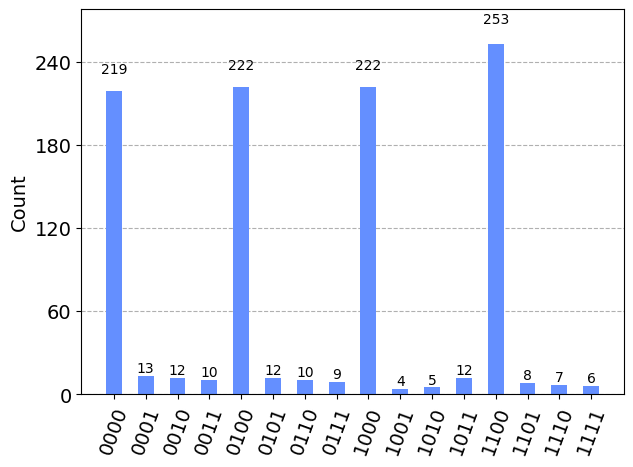

In [6]:
# Run simualtion
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(Q, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [7]:
## Compute the continuous fraction, and obtain from there the candidate factors:

rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)

    # Add these values to the rows in our table:
    frac = Fraction(phase).limit_denominator(N)
    #rows.append([f"{output}(bin) = {decimal:>3}(dec)", f"{decimal}/{2**n_count} = {phase:.2f}",f"{frac.numerator}/{frac.denominator}", frac.denominator, np.gcd(x**(frac.denominator//2)-1, N), np.gcd(x**(frac.denominator//2)+1, N)])
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", f"{frac.numerator}/{frac.denominator}", frac.denominator, np.gcd(x**(frac.denominator//2)-1, N), np.gcd(x**(frac.denominator//2)+1, N)])
# Print the rows in a table
#headers=["Register Output", "Phase", "Fraction", "Guess for r", "guess1","guess2"]
headers=["Register Output", "Fraction", "Guess for r", "guess1","guess2"]
df = pd.DataFrame(rows, columns=headers)
print(df)

         Register Output Fraction  Guess for r  guess1  guess2
0   1001(bin) =   9(dec)      5/9            9       5       1
1   1010(bin) =  10(dec)      5/8            8       5       1
2   0101(bin) =   5(dec)     4/13           13       1       5
3   0111(bin) =   7(dec)      4/9            9       5       1
4   1111(bin) =  15(dec)    14/15           15       1       1
5   1101(bin) =  13(dec)     9/11           11       1       1
6   1011(bin) =  11(dec)     9/13           13       1       5
7   1110(bin) =  14(dec)      7/8            8       5       1
8   1000(bin) =   8(dec)      1/2            2       1       1
9   0100(bin) =   4(dec)      1/4            4       1       5
10  1100(bin) =  12(dec)      3/4            4       1       5
11  0011(bin) =   3(dec)     2/11           11       1       1
12  0001(bin) =   1(dec)     1/15           15       1       1
13  0110(bin) =   6(dec)      3/8            8       5       1
14  0010(bin) =   2(dec)      1/8            8       5 

## Assignement 

For the assignement I choose the number: N=21 and x= 3,4,5,9.

In [56]:
N=21
x_=[2,3,8,18]

In [57]:
def expansion(x,N,p=3):
    s=x**1%N
    k=1
    xpmo= []
    while p!=0:
        pmo=x**k%N
#         print(pmo)
        xpmo.append(pmo)
        if pmo==s:
            p=p-1
        k+=1
    return xpmo, k


In [58]:
px_=[]
for x in x_:
    pmo, k = expansion(x,N)
    print("x={}, k={}".format(x,k))
    px_.append( [pmo , k])

x=2, k=14
x=3, k=14
x=8, k=6
x=18, k=8


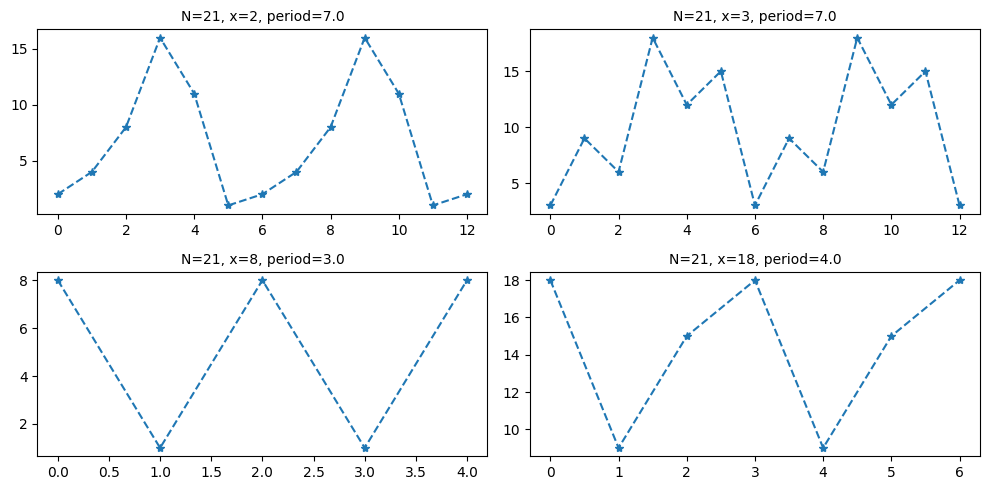

In [59]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(10, 5))

for i, x in enumerate(x_):
    ax[int(i/2),i%2].plot( px_[i][0] , "*--")
    ax[int(i/2),i%2].set_title("N={}, x={}, period={}".format(N, x, px_[i][1]/2), fontsize = 10)


plt.tight_layout()
plt.show()

In [44]:
def get_counts(x,N,n_q, n_count):
    vec = get_coeffs(x, N, n_q, n_count)
    vec =  np.multiply(vec, 1/np.sqrt(2**n_count))

    Q = QuantumCircuit(n_q,n_count)
    Q.initialize(vec)

    Q.append(qft_dagger(n_count),range(n_count))
    Q.measure(range(n_count),range(n_count))
    # Q.draw(fold=-1)  # -1 means 'do not fold'

    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(Q, aer_sim)
    qobj = assemble(t_qc)
    results = aer_sim.run(qobj).result()
    counts = results.get_counts()
    
    return counts

In [70]:
nr_qubit_d = 5# nr o qubits without the qubits for qft (without the first t qubits)
experiments= {2:{}, 3:{},4:{},5:{}, 6:{}}

for t in experiments.keys():
    experiments[t]["counts"]= []
    for x in x_:
        print("t={}|x={}".format(t,x))
        experiments[t]["counts"].append(get_counts(x,N,nr_qubit_d+t, n_count=t))
    print("\n\n")

t=2|x=2
0 1 00 00001
1 2 01 00010
2 4 10 00100
3 8 11 01000
t=2|x=3
0 1 00 00001
1 3 01 00011
2 9 10 01001
3 6 11 00110
t=2|x=8
0 1 00 00001
1 8 01 01000
2 1 10 00001
3 8 11 01000
t=2|x=18
0 1 00 00001
1 18 01 10010
2 9 10 01001
3 15 11 01111



t=3|x=2
0 1 000 00001
1 2 001 00010
2 4 010 00100
3 8 011 01000
4 16 100 10000
5 11 101 01011
6 1 110 00001
7 2 111 00010
t=3|x=3
0 1 000 00001
1 3 001 00011
2 9 010 01001
3 6 011 00110
4 18 100 10010
5 12 101 01100
6 15 110 01111
7 3 111 00011
t=3|x=8
0 1 000 00001
1 8 001 01000
2 1 010 00001
3 8 011 01000
4 1 100 00001
5 8 101 01000
6 1 110 00001
7 8 111 01000
t=3|x=18
0 1 000 00001
1 18 001 10010
2 9 010 01001
3 15 011 01111
4 18 100 10010
5 9 101 01001
6 15 110 01111
7 18 111 10010



t=4|x=2
0 1 0000 00001
1 2 0001 00010
2 4 0010 00100
3 8 0011 01000
4 16 0100 10000
5 11 0101 01011
6 1 0110 00001
7 2 0111 00010
8 4 1000 00100
9 8 1001 01000
10 16 1010 10000
11 11 1011 01011
12 1 1100 00001
13 2 1101 00010
14 4 1110 00100
15 8 1111 01000
t=

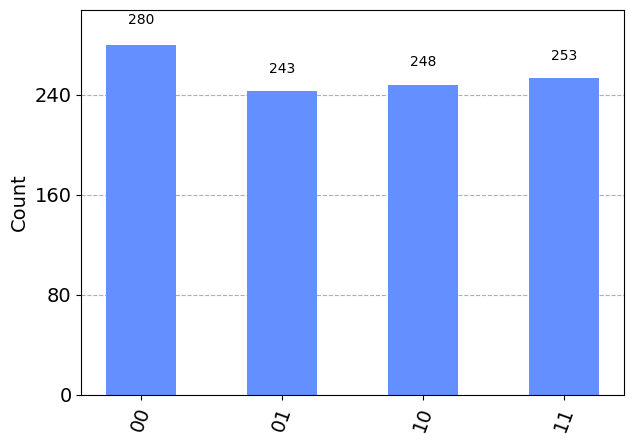

In [74]:
hist = plot_histogram(experiments[2]["counts"][0])
hist

In [79]:
n_count=6
counts = experiments[n_count]["counts"][3]

rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)

    # Add these values to the rows in our table:
    frac = Fraction(phase).limit_denominator(N)
    #rows.append([f"{output}(bin) = {decimal:>3}(dec)", f"{decimal}/{2**n_count} = {phase:.2f}",f"{frac.numerator}/{frac.denominator}", frac.denominator, np.gcd(x**(frac.denominator//2)-1, N), np.gcd(x**(frac.denominator//2)+1, N)])
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", f"{frac.numerator}/{frac.denominator}", frac.denominator, np.gcd(x**(frac.denominator//2)-1, N), np.gcd(x**(frac.denominator//2)+1, N)])
# Print the rows in a table
#headers=["Register Output", "Phase", "Fraction", "Guess for r", "guess1","guess2"]
headers=["Register Output", "Fraction", "Guess for r", "guess1","guess2"]
df = pd.DataFrame(rows, columns=headers)
print(df)

           Register Output Fraction  Guess for r  guess1  guess2
0   011011(bin) =  27(dec)     8/19           19       7       1
1   101101(bin) =  45(dec)    12/17           17       1       1
2   100101(bin) =  37(dec)    11/19           19       7       1
3   001000(bin) =   8(dec)      1/8            8       1       1
4   111000(bin) =  56(dec)      7/8            8       1       1
5   100110(bin) =  38(dec)    10/17           17       1       1
6   001011(bin) =  11(dec)     3/17           17       1       1
7   001100(bin) =  12(dec)     3/16           16       1       1
8   100111(bin) =  39(dec)    11/18           18       7       1
9   011010(bin) =  26(dec)     7/17           17       1       1
10  110010(bin) =  50(dec)      7/9            9       1       1
11  010111(bin) =  23(dec)     5/14           14       1       1
12  001110(bin) =  14(dec)      2/9            9       1       1
13  010011(bin) =  19(dec)     5/17           17       1       1
14  001111(bin) =  15(dec